In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
# Supervised Learning

# Paths
merged_dataset_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset'
combined_csv_path = '/Users/maggie/Desktop/project_3/Plant_ID_and_Diagnosis/Resources/plant_dr_master_dataset/master_dataset/combined_labels.csv'

# Load the CSV file
df = pd.read_csv(combined_csv_path)

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print the distribution to verify the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

# ImageDataGenerator setup
img_size = (128, 128)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,       # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,          # Randomly zoom image
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Points outside the boundaries of the input are filled according to the given mode
)

# Load training data using flow_from_dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=merged_dataset_path,
    x_col='filename',  # Column name in the CSV file that contains the image file names
    y_col='label',  # Column name in the CSV file that contains the labels
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load validation data using flow_from_dataframe
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=merged_dataset_path,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load test data using flow_from_dataframe
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=merged_dataset_path,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle for testing
)

# Load the base model (EfficientNetB0)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x1 = GlobalAveragePooling2D()(base_model.output)
x2 = Dense(1024, activation='relu')(x1)

# Determine the number of classes
num_classes = len(train_generator.class_indices)  # Number of unique classes

# Output layer
x3 = Dense(num_classes, activation='softmax')(x2)

model = Model(inputs=base_model.input, outputs=x3)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=valid_generator, epochs=7)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training set size: 56641
Validation set size: 12137
Test set size: 12138
Found 56641 validated image filenames belonging to 171 classes.
Found 12137 validated image filenames belonging to 171 classes.
Found 12138 validated image filenames belonging to 171 classes.
Epoch 1/7


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1771/1771 ━━━━━━━━━━━━━━━━━━━━ 841s 469ms/step - accuracy: 0.0634 - loss: 4.2645 - val_accuracy: 0.0662 - val_loss: 4.2227
Epoch 2/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 845s 477ms/step - accuracy: 0.0668 - loss: 4.2099 - val_accuracy: 0.0681 - val_loss: 4.2121
Epoch 3/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 871s 491ms/step - accuracy: 0.0676 - loss: 4.2040 - val_accuracy: 0.0662 - val_loss: 4.2116
Epoch 4/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 864s 488ms/step - accuracy: 0.0688 - loss: 4.2094 - val_accuracy: 0.0629 - val_loss: 4.2099
Epoch 5/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 931s 525ms/step - accuracy: 0.0675 - loss: 4.2044 - val_accuracy: 0.0662 - val_loss: 4.2034
Epoch 6/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 947s 534ms/step - accuracy: 0.0664 - loss: 4.2071 - val_accuracy: 0.0662 - val_loss: 4.2107
Epoch 7/7
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 892s 503ms/step - accuracy: 0.0648 - loss: 4.2075 - val_accuracy: 0.0681 - val_loss: 4.2041
380/380 ━━━━━━━━━━━━━━━━━━━━ 162s 426ms/step - accuracy: 0.0668 - loss: 4.1801


In [3]:
# Evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


380/380 ━━━━━━━━━━━━━━━━━━━━ 160s 420ms/step - accuracy: 0.0723 - loss: 4.2003
Validation Loss: 4.204121112823486
Validation Accuracy: 0.06805635988712311


In [4]:
# Unfreeze the last few layers of the EfficientNetB0 model for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Re-train the model with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=8
)


Epoch 1/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 973s 542ms/step - accuracy: 0.0703 - loss: 4.2519 - val_accuracy: 0.0681 - val_loss: 4.2072
Epoch 2/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 946s 533ms/step - accuracy: 0.0668 - loss: 4.1949 - val_accuracy: 0.0681 - val_loss: 4.2060
Epoch 3/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 949s 535ms/step - accuracy: 0.0675 - loss: 4.2018 - val_accuracy: 0.0662 - val_loss: 4.1907
Epoch 4/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 921s 519ms/step - accuracy: 0.0699 - loss: 4.1843 - val_accuracy: 0.0739 - val_loss: 4.1785
Epoch 5/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 942s 531ms/step - accuracy: 0.0699 - loss: 4.1804 - val_accuracy: 0.0662 - val_loss: 4.1698
Epoch 6/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 940s 530ms/step - accuracy: 0.0700 - loss: 4.1699 - val_accuracy: 0.0662 - val_loss: 4.1600
Epoch 7/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 951s 536ms/step - accuracy: 0.0745 - loss: 4.1597 - val_accuracy: 0.0664 - val_loss: 4.1456
Epoch 8/8
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 920s 519ms/step - accuracy: 

In [5]:
# Evaluate the model on the validation set

val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


380/380 ━━━━━━━━━━━━━━━━━━━━ 144s 379ms/step - accuracy: 0.0856 - loss: 4.1550
Validation Loss: 4.176595687866211
Validation Accuracy: 0.07901458442211151


380/380 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step


NameError: name 'keras_image' is not defined

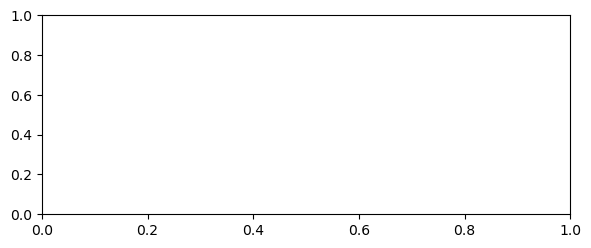

In [8]:
# Obtain predictions for the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Identify misclassified indices
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Map class indices to class labels
class_labels = list(test_generator.class_indices.keys())

# Display some misclassified images
num_misclassified_to_display = 10  # Number of misclassified images to display
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:num_misclassified_to_display]):
    plt.subplot(5, 2, i + 1)
    
    # Load and preprocess the image
    img_path = test_generator.filepaths[index]
    img = keras_image.load_img(img_path, target_size=(128, 128))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Rescale if needed
    
    plt.imshow(img[0])
    plt.axis('off')
    
    true_label = class_labels[true_labels[index]]
    predicted_label = class_labels[predicted_labels[index]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()


In [ ]:
# # Unsupervised Learning - Apply only after training is complete

# # Extract features
# feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)  # Using the layer before the output
# features = feature_model.predict(train_generator)  # Using the training set for feature extraction

# # Apply PCA
# pca = PCA(n_components=50)
# reduced_features = pca.fit_transform(features)

# # Apply K-Means Clustering
# kmeans = KMeans(n_clusters=10)
# clusters = kmeans.fit_predict(reduced_features)

# # Visualize clusters
# plt.figure(figsize=(10, 7))
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
# plt.colorbar()
# plt.title('K-Means Clustering of Plant and Ailment Features')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.show()
